I want to try to use a Graph Neural Network to use the data from the connectome matrix separate from any other data.

In [598]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    recall_score,
)

import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx


import xgboost as xgb

import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, global_mean_pool, global_max_pool
from torch_geometric.data import DataLoader

In [599]:
# Use read_excel and use participant_id as the index
train_cat = pd.read_excel("../data/TRAIN_NEW/TRAIN_CATEGORICAL_METADATA_new.xlsx")
train_func = pd.read_csv(
    "../data/TRAIN_NEW/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv"
)
train_quant = pd.read_excel("../data/TRAIN_NEW/TRAIN_QUANTITATIVE_METADATA_new.xlsx")
train_soln = pd.read_excel("../data/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx")

In [600]:
Basic_Demos_Study_Site = {
    1: "Staten Island",
    2: "MRV",
    3: "Midtown",
    4: "Harlem",
    5: "SI RUMC",
}

PreInt_Demos_Fam_Child_Ethnicity = {
    0: "Not Hispanic or Latino",
    1: "Hispanic or Latino",
    2: "Decline to specify",
    3: "Unknown",
}

PreInt_Demos_Fam_Child_Race = {
    0: "White/Caucasian",
    1: "Black/African American",
    2: "Hispanic",
    3: "Asian",
    4: "Indian",
    5: "Native American Indian",
    6: "American Indian/Alaskan Native",
    7: "Native Hawaiian/Other Pacific Islander",
    8: "Two or more races",
    9: "Other race",
    10: "Unknown",
    11: "Chose not to specify",
}

MRI_Track_Scan_Location = {1: "Staten Island", 2: "RUBIC", 3: "CBIC", 4: "CUNY"}

Barratt_Barratt_P1_Edu = {
    3: "Less than 7th grade",
    6: "Junior high/Middle school (9th grade)",
    9: "Partial high school (10th or 11th grade)",
    12: "High school graduate",
    15: "Partial college (at least one year)",
    18: "College education",
    21: "Graduate degree",
}

Barratt_Barratt_P1_Occ = {
    0: "Homemaker, stay at home parent.",
    5: "Day laborer, janitor, house cleaner, farm worker, food counter sales, food preparation worker, busboy.",
    10: "Garbage collector, short-order cook, cab driver, shoe sales, assembly line workers, masons, baggage porter.",
    15: "Painter, skilled construction trade, sales clerk, truck driver, cook, sales counter or general office clerk.",
    20: "Automobile mechanic, typist, locksmith, farmer, carpenter, receptionist, construction laborer, hairdresser.",
    25: "Machinist, musician, bookkeeper, secretary, insurance sales, cabinet maker, personnel specialist, welder.",
    30: "Supervisor, librarian, aircraft mechanic, artist and artisan, electrician, administrator, military enlisted personnel, buyer.",
    35: "Nurse, skilled technician, medical technician, counselor, manager, police and fire personnel, financial manager, physical, occupational, speech therapist.",
    40: "Mechanical, nuclear, and electrical engineer, educational administrator, veterinarian, military officer, elementary, high school and special education teacher.",
    45: "Physician, attorney, professor, chemical and aerospace engineer, judge, CEO, senior manager, public official, psychologist, pharmacist, accountant.",
}

Barratt_Barratt_P2_Edu = {
    3: "Less than 7th grade",
    6: "Junior high/Middle school (9th grade)",
    9: "Partial high school (10th or 11th grade)",
    12: "High school graduate",
    15: "Partial college (at least one year)",
    18: "College education",
    21: "Graduate degree",
}

Barratt_Barratt_P2_Occ = {
    0: "Homemaker, stay at home parent.",
    5: "Day laborer, janitor, house cleaner, farm worker, food counter sales, food preparation worker, busboy.",
    10: "Garbage collector, short-order cook, cab driver, shoe sales, assembly line workers, masons, baggage porter.",
    15: "Painter, skilled construction trade, sales clerk, truck driver, cook, sales counter or general office clerk.",
    20: "Automobile mechanic, typist, locksmith, farmer, carpenter, receptionist, construction laborer, hairdresser.",
    25: "Machinist, musician, bookkeeper, secretary, insurance sales, cabinet maker, personnel specialist, welder.",
    30: "Supervisor, librarian, aircraft mechanic, artist and artisan, electrician, administrator, military enlisted personnel, buyer.",
    35: "Nurse, skilled technician, medical technician, counselor, manager, police and fire personnel, financial manager, physical, occupational, speech therapist.",
    40: "Mechanical, nuclear, and electrical engineer, educational administrator, veterinarian, military officer, elementary, high school and special education teacher.",
    45: "Physician, attorney, professor, chemical and aerospace engineer, judge, CEO, senior manager, public official, psychologist, pharmacist, accountant.",
}

In [601]:
# Apply label replacements using the dictionaries
train_cat["Basic_Demos_Study_Site"] = train_cat["Basic_Demos_Study_Site"].replace(
    Basic_Demos_Study_Site
)
train_cat["PreInt_Demos_Fam_Child_Ethnicity"] = train_cat[
    "PreInt_Demos_Fam_Child_Ethnicity"
].replace(PreInt_Demos_Fam_Child_Ethnicity)
train_cat["PreInt_Demos_Fam_Child_Race"] = train_cat[
    "PreInt_Demos_Fam_Child_Race"
].replace(PreInt_Demos_Fam_Child_Race)
train_cat["MRI_Track_Scan_Location"] = train_cat["MRI_Track_Scan_Location"].replace(
    MRI_Track_Scan_Location
)
train_cat["Barratt_Barratt_P1_Edu"] = train_cat["Barratt_Barratt_P1_Edu"].replace(
    Barratt_Barratt_P1_Edu
)
train_cat["Barratt_Barratt_P1_Occ"] = train_cat["Barratt_Barratt_P1_Occ"].replace(
    Barratt_Barratt_P1_Occ
)
train_cat["Barratt_Barratt_P2_Edu"] = train_cat["Barratt_Barratt_P2_Edu"].replace(
    Barratt_Barratt_P2_Edu
)
train_cat["Barratt_Barratt_P2_Occ"] = train_cat["Barratt_Barratt_P2_Occ"].replace(
    Barratt_Barratt_P2_Occ
)

In [602]:
# One-hot encode all columns except 'participant_id' and 'Basic_Demos_Enroll_Year'
train_cat_encoded = pd.get_dummies(
    train_cat,
    columns=[
        "Basic_Demos_Study_Site",
        "PreInt_Demos_Fam_Child_Ethnicity",
        "PreInt_Demos_Fam_Child_Race",
        "MRI_Track_Scan_Location",
        "Barratt_Barratt_P1_Edu",
        "Barratt_Barratt_P1_Occ",
        "Barratt_Barratt_P2_Edu",
        "Barratt_Barratt_P2_Occ",
    ],
    dummy_na=True,  # Optional: adds a column for NaNs if present
    drop_first=False,  # Set to True if you want to drop the first category to avoid multicollinearity
)

# Check the result
train_cat_encoded.head()

,participant_id,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site_Harlem,Basic_Demos_Study_Site_MRV,Basic_Demos_Study_Site_Midtown,Basic_Demos_Study_Site_Staten Island,Basic_Demos_Study_Site_nan,PreInt_Demos_Fam_Child_Ethnicity_Decline to specify,PreInt_Demos_Fam_Child_Ethnicity_Hispanic or Latino,PreInt_Demos_Fam_Child_Ethnicity_Not Hispanic or Latino,...,"Barratt_Barratt_P2_Occ_Day laborer, janitor, house cleaner, farm worker, food counter sales, food preparation worker, busboy.","Barratt_Barratt_P2_Occ_Garbage collector, short-order cook, cab driver, shoe sales, assembly line workers, masons, baggage porter.","Barratt_Barratt_P2_Occ_Homemaker, stay at home parent.","Barratt_Barratt_P2_Occ_Machinist, musician, bookkeeper, secretary, insurance sales, cabinet maker, personnel specialist, welder.","Barratt_Barratt_P2_Occ_Mechanical, nuclear, and electrical engineer, educational administrator, veterinarian, military officer, elementary, high school and special education teacher.","Barratt_Barratt_P2_Occ_Nurse, skilled technician, medical technician, counselor, manager, police and fire personnel, financial manager, physical, occupational, speech therapist.","Barratt_Barratt_P2_Occ_Painter, skilled construction trade, sales clerk, truck driver, cook, sales counter or general office clerk.","Barratt_Barratt_P2_Occ_Physician, attorney, professor, chemical and aerospace engineer, judge, CEO, senior manager, public official, psychologist, pharmacist, accountant.","Barratt_Barratt_P2_Occ_Supervisor, librarian, aircraft mechanic, artist and artisan, electrician, administrator, military enlisted personnel, buyer.",Barratt_Barratt_P2_Occ_nan
0,00aIpNTbG5uh,2019,True,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
1,00fV0OyyoLfw,2017,False,False,False,True,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False
2,04X1eiS79T4B,2017,False,False,False,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
3,05ocQutkURd6,2018,False,False,False,True,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
4,06YUNBA9ZRLq,2018,False,False,False,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True


In [603]:
# Deal with NaN values
train_quant = train_quant.fillna(train_quant.drop("participant_id", axis=1).mean())
train_quant.head()

,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,00aIpNTbG5uh,100.00,13.0,3.0,15.0,44.0,14.0,20.0,27.0,3.0,17.0,4.0,11.0,5.0,8.0,6.0,2.0,9.0,14.274127
1,00fV0OyyoLfw,92.27,14.0,3.0,12.0,35.0,25.0,28.0,30.0,5.0,20.0,4.0,13.0,5.0,8.0,7.0,3.0,8.0,11.245678
2,04X1eiS79T4B,86.67,14.0,3.0,21.0,37.0,18.0,26.0,28.0,3.0,24.0,7.0,10.0,10.0,7.0,14.0,7.0,7.0,13.463381
3,05ocQutkURd6,93.34,14.0,3.0,11.0,42.0,15.0,20.0,28.0,0.0,5.0,0.0,3.0,0.0,3.0,2.0,2.0,6.0,9.572553
4,06YUNBA9ZRLq,0.00,14.0,8.0,12.0,35.0,22.0,12.0,24.0,6.0,23.0,7.0,15.0,8.0,9.0,8.0,1.0,4.0,6.654574


In [604]:
# Save participant IDs before dropping the column
train_func_ids = train_func["participant_id"]

# Drop participant_id from features before splitting
train_func_no_id = train_func.drop(columns=["participant_id"])

# Target labels
y_sex = train_soln["Sex_F"]
y_adhd = train_soln["ADHD_Outcome"]

# Split features and labels
X_train, X_val, y_train_adhd, y_val_adhd, y_train_sex, y_val_sex = train_test_split(
    train_func_no_id, y_adhd, y_sex, test_size=0.2, random_state=42
)

# Use the saved participant IDs to track train/val split
train_func_ids_train = train_func_ids.loc[X_train.index].values
train_func_ids_val = train_func_ids.loc[X_val.index].values

## Step 1: convert connectome matrix back into symmetric matrix
- Nodes: brain regions
- Edges: weighted by correlations between regions

In [605]:
def vector_to_symmetric_matrix(upper_tri_vector, n_nodes):
    """
    Convert a 1D array representing the upper triangle of a symmetric matrix
    (excluding the diagonal) back into a full symmetric matrix.

    Args:
        upper_tri_vector (np.array): Flattened upper triangle (length = n_nodes * (n_nodes - 1) / 2)
        n_nodes (int): Number of nodes in the original matrix

    Returns:
        np.array: n_nodes x n_nodes symmetric matrix
    """
    # Initialize empty symmetric matrix
    mat = np.zeros((n_nodes, n_nodes))

    # Get upper triangle indices (excluding diagonal)
    upper_tri_indices = np.triu_indices(n_nodes, k=1)

    # Fill in upper triangle
    mat[upper_tri_indices] = upper_tri_vector

    # Mirror to lower triangle
    mat[(upper_tri_indices[1], upper_tri_indices[0])] = upper_tri_vector

    return mat

In [606]:
# Create the adjacency matrices for the training set
train_matrices = []
valid_matrices = []

for i in range(len(X_train)):
    row_vector = X_train.iloc[i].astype(float).values
    matrix = vector_to_symmetric_matrix(row_vector, n_nodes=200)
    train_matrices.append(matrix)

for i in range(len(X_val)):
    valid_vector = X_val.iloc[i].astype(float).values
    valid_mat = vector_to_symmetric_matrix(valid_vector, n_nodes=200)
    valid_matrices.append(valid_mat)

# Convert to NumPy array if needed
train_matrices = np.array(train_matrices)
valid_matrices = np.array(valid_matrices)

Ok, now each person's functional MRI data has been converted back into this matrix, which we can visualize as a heatmap to see brain activity!

1

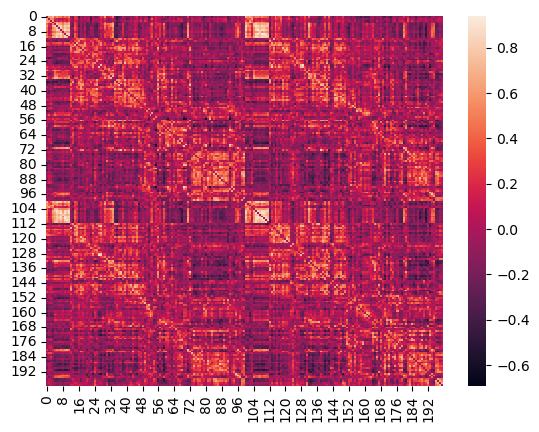

In [607]:
sns.heatmap(train_matrices[0])
y_train_adhd[0]

In [608]:
def create_graph_from_matrix(adj_matrix, labels=None, threshold=0.4):
    # Apply thresholding to keep only strong connections
    mask = np.abs(adj_matrix) > threshold
    row, col = np.nonzero(mask)
    edge_index = torch.tensor([row, col], dtype=torch.long)
    edge_attr = torch.tensor(adj_matrix[mask], dtype=torch.float)

    # Node features as identity
    x = torch.eye(adj_matrix.shape[0], dtype=torch.float)

    # Label
    y = torch.tensor(labels, dtype=torch.long) if labels is not None else None

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

In [609]:
## For ADHD
train_data_objs_adhd = []
valid_objs_adhd = []

for i in range(len(train_matrices)):
    label = int(y_train_adhd.iloc[i])  # Accessing y_train_adhd with correct index
    train_data_objs_adhd.append(create_graph_from_matrix(train_matrices[i], labels=label))

for i in range(len(valid_matrices)):
    valid_objs_adhd.append(create_graph_from_matrix(valid_matrices[i], labels = y_val_adhd.iloc[i]))

train_loader_adhd = DataLoader(
    train_data_objs_adhd, batch_size=64, shuffle=True
)  # Adjust batch size as needed

valid_loader_adhd = DataLoader(
    valid_objs_adhd, batch_size=32, shuffle=True
)

/opt/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [610]:
## For sex
train_data_objs_sex = []
valid_objs_sex = []

for i in range(len(train_matrices)):
    label = int(y_train_sex.iloc[i])  # Accessing y_train_adhd with correct index
    train_data_objs_sex.append(
        create_graph_from_matrix(train_matrices[i], labels=label)
    )

for i in range(len(valid_matrices)):
    valid_objs_sex.append(
        create_graph_from_matrix(valid_matrices[i], labels=y_val_sex.iloc[i])
    )

train_loader_sex = DataLoader(
    train_data_objs_sex, batch_size=32, shuffle=True
)  # Adjust batch size as needed

valid_loader_sex = DataLoader(valid_objs_sex, batch_size=32, shuffle=True)

In [611]:
class BrainGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(BrainGNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.pool = global_max_pool

        self.fc = nn.Linear(hidden_channels, out_channels)

    def forward(self, data):
        # Batch each Data object using DataLoader
        x, edge_index, edge_attr, batch = (
            data.x,
            data.edge_index,
            data.edge_attr,
            data.batch,
        )

        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)

        x = self.pool(x, batch)
        return self.fc(x)

In [612]:
# === STEP 1: Compute class weights for ADHD ===
class_weights_adhd = compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train_adhd), y=y_train_adhd.values
)
class_weights_adhd_tensor = torch.tensor(class_weights_adhd, dtype=torch.float)

# === STEP 2: Define models ===
model_adhd = BrainGNN(in_channels=200, hidden_channels=64, out_channels=2)
model_sex = BrainGNN(in_channels=200, hidden_channels=64, out_channels=2)

# === STEP 3: Define optimizer and loss (for ADHD) ===
optimizer_adhd = optim.Adam(model_adhd.parameters(), lr=0.001)
criterion_adhd = nn.CrossEntropyLoss(weight=class_weights_adhd_tensor)

# === STEP 4: Train ADHD model ===
print("Training ADHD model...")
for epoch in range(50):
    model_adhd.train()
    total_loss = 0
    for data in train_loader_adhd:  # Make sure this loader has `data.y = y_train_adhd`
        optimizer_adhd.zero_grad()
        output = model_adhd(data)
        loss = criterion_adhd(output, data.y)
        loss.backward()
        optimizer_adhd.step()
        total_loss += loss.item()
    if (epoch % 10 == 0):
        print(f"[ADHD] Epoch {epoch+1}, Loss: {total_loss / len(train_loader_adhd)}")

# === STEP 5: Train Sex model ===
# Optional: compute class weights for sex labels if imbalanced
class_weights_sex = compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train_sex), y=y_train_sex.values
)
class_weights_sex_tensor = torch.tensor(class_weights_sex, dtype=torch.float)

optimizer_sex = optim.Adam(model_sex.parameters(), lr=0.001)
criterion_sex = nn.CrossEntropyLoss(weight=class_weights_sex_tensor)

print("Training Sex model...")
for epoch in range(50):
    model_sex.train()
    total_loss = 0
    for data in train_loader_sex:  # Make sure this loader has `data.y = y_train_sex`
        optimizer_sex.zero_grad()
        output = model_sex(data)
        loss = criterion_sex(output, data.y)
        loss.backward()
        optimizer_sex.step()
        total_loss += loss.item()
    if (epoch % 10 == 0):
        print(f"[Sex] Epoch {epoch+1}, Loss: {total_loss / len(train_loader_sex)}")

Training ADHD model...
[ADHD] Epoch 1, Loss: 0.6957689113914967
[ADHD] Epoch 11, Loss: 0.6737652011215687
[ADHD] Epoch 21, Loss: 0.61436478048563
[ADHD] Epoch 31, Loss: 0.5561471879482269
[ADHD] Epoch 41, Loss: 0.5032087713479996
Training Sex model...
[Sex] Epoch 1, Loss: 0.6941631436347961
[Sex] Epoch 11, Loss: 0.6510091116351466
[Sex] Epoch 21, Loss: 0.5600889007891378
[Sex] Epoch 31, Loss: 0.4540083783288156
[Sex] Epoch 41, Loss: 0.3679682136543335


In [613]:
def evaluate(model, valid_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in valid_loader:
            output = model(data)
            _, preds = torch.max(output, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)

    return accuracy, f1, recall, np.array(all_preds), np.array(all_labels)

In [614]:
acc_adhd, f1_adhd, recall_adhd, gnn_pred_adhd, y_val_adhd = evaluate(
    model_adhd, valid_loader_adhd
)
print(
    f"[ADHD] Accuracy: {acc_adhd:.4f}, F1 Score: {f1_adhd:.4f}, Recall: {recall_adhd:.4f}"
)

acc_sex, f1_sex, recall_sex, gnn_pred_sex, y_val_sex = evaluate(
    model_sex, valid_loader_sex
)
print(
    f"[Sex] Accuracy: {acc_sex:.4f}, F1 Score: {f1_sex:.4f}, Recall: {recall_sex:.4f}"
)

[ADHD] Accuracy: 0.5926, F1 Score: 0.7147, Recall: 0.6966
[Sex] Accuracy: 0.5391, F1 Score: 0.2911, Recall: 0.3194


## Other data

In [615]:
# Merge features
X = pd.merge(train_quant, train_cat_encoded, on="participant_id").drop(
    columns=["participant_id"]
)

# Train/test split for sex prediction
X_train, X_val, y_train_sex, y_val_sex = train_test_split(
    X, y_sex, test_size=0.2, random_state=42, stratify=y_sex
)

# Initialize Random Forest model
rf_model_sex = RandomForestClassifier(
    n_estimators=100, max_depth=1, random_state=42, n_jobs=-1, class_weight="balanced"
)

# Train the model
rf_model_sex.fit(X_train, y_train_sex)

# Predict
y_pred_sex = rf_model_sex.predict(X_val)

# Evaluation
print("=== Random Forest Results (Sex Prediction) ===")
print(f"Accuracy: {accuracy_score(y_val_sex, y_pred_sex):.3f}")
print(f"F1 Score: {f1_score(y_val_sex, y_pred_sex):.3f}")
print(f"Recall: {recall_score(y_val_sex, y_pred_sex):.3f}")
print("\nDetailed Classification Report:")
print(classification_report(y_val_sex, y_pred_sex))

=== Random Forest Results (Sex Prediction) ===
Accuracy: 0.465
F1 Score: 0.369
Recall: 0.458

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.47      0.54       160
           1       0.31      0.46      0.37        83

    accuracy                           0.47       243
   macro avg       0.47      0.46      0.45       243
weighted avg       0.52      0.47      0.48       243



In [616]:
# Merge features
X = pd.merge(train_quant, train_cat_encoded, on="participant_id").drop(
    columns=["participant_id"]
)

# Train/test split for sex prediction
X_train, X_val, y_train_sex, y_val_sex = train_test_split(
    X, y_adhd, test_size=0.2, random_state=42, stratify=y_adhd
)

# Initialize Random Forest model
rf_model_adhd = RandomForestClassifier(
    n_estimators=100, max_depth=100, random_state=42, n_jobs=-1, class_weight="balanced"
)

# Train the model
rf_model_adhd.fit(X_train, y_train_adhd)

# Predict
y_pred_adhd = rf_model_adhd.predict(X_val)

# Evaluation
print("=== Random Forest Results (Sex Prediction) ===")
print(f"Accuracy: {accuracy_score(y_val_adhd, y_pred_adhd):.3f}")
print(f"F1 Score: {f1_score(y_val_adhd, y_pred_adhd):.3f}")
print(f"Recall: {recall_score(y_val_adhd, y_pred_adhd):.3f}")
print("\nDetailed Classification Report:")
print(classification_report(y_val_adhd, y_pred_adhd))

=== Random Forest Results (Sex Prediction) ===
Accuracy: 0.716
F1 Score: 0.834
Recall: 0.972

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.02      0.03        65
           1       0.73      0.97      0.83       178

    accuracy                           0.72       243
   macro avg       0.45      0.49      0.43       243
weighted avg       0.58      0.72      0.62       243



In [617]:
def penalized_combination_f1(y_true_sex, y_true_adhd, y_pred_sex, y_pred_adhd):
    # Create a weight array for ADHD outcome: double weight if female ADHD case
    weight = 1 + ((y_true_sex == 1) & (y_true_adhd == 1)).astype(int)

    # E.g. if patient is actually a female with adhd, this gets a weight of 2

    # Custom F1 score for ADHD with sample weights
    f1_adhd = f1_score(y_true_adhd, y_pred_adhd, sample_weight=weight)

    # Custom F1 core for sex with sample weights
    f1_sex = f1_score(y_true_sex, y_pred_sex, sample_weight=weight)

    return 0.5 * (f1_adhd + f1_sex)

## Decide which classification to model for each category

In [618]:
# Example: ensure RF predictions are NumPy arrays
rf_pred_sex = np.array(y_pred_sex)
rf_pred_adhd = np.array(y_pred_adhd)

# Compute Penalized F1
rf_comb_f1 = penalized_combination_f1(y_val_sex, y_val_adhd, rf_pred_sex, rf_pred_adhd)
gnn_comb_f1 = penalized_combination_f1(
    y_val_sex, y_val_adhd, gnn_pred_sex, gnn_pred_adhd
)
rf_gnn = penalized_combination_f1(y_val_sex, y_val_adhd, rf_pred_sex, gnn_pred_adhd)

print("Penalized F1 - Random Forest:", rf_comb_f1)
print("Penalized F1 - GNN:", gnn_comb_f1)
print(f"GNN for ADHD, rf for sex: {rf_gnn}")

Penalized F1 - Random Forest: 0.7580947676863415
Penalized F1 - GNN: 0.6244759936421312
GNN for ADHD, rf for sex: 0.6908369493910006


## Test data

In [619]:
# Load the testing data
test_cat = pd.read_excel("../data/TEST/TEST_CATEGORICAL.xlsx")
test_func = pd.read_csv("../data/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv")
test_quant = pd.read_excel("../data/TEST/TEST_QUANTITATIVE_METADATA.xlsx")

In [620]:
# Apply label replacements for the test data (same as for training data)
test_cat["Basic_Demos_Study_Site"] = test_cat["Basic_Demos_Study_Site"].replace(
    Basic_Demos_Study_Site
)
test_cat["PreInt_Demos_Fam_Child_Ethnicity"] = test_cat[
    "PreInt_Demos_Fam_Child_Ethnicity"
].replace(PreInt_Demos_Fam_Child_Ethnicity)
test_cat["PreInt_Demos_Fam_Child_Race"] = test_cat[
    "PreInt_Demos_Fam_Child_Race"
].replace(PreInt_Demos_Fam_Child_Race)
test_cat["MRI_Track_Scan_Location"] = test_cat["MRI_Track_Scan_Location"].replace(
    MRI_Track_Scan_Location
)
test_cat["Barratt_Barratt_P1_Edu"] = test_cat["Barratt_Barratt_P1_Edu"].replace(
    Barratt_Barratt_P1_Edu
)
test_cat["Barratt_Barratt_P1_Occ"] = test_cat["Barratt_Barratt_P1_Occ"].replace(
    Barratt_Barratt_P1_Occ
)
test_cat["Barratt_Barratt_P2_Edu"] = test_cat["Barratt_Barratt_P2_Edu"].replace(
    Barratt_Barratt_P2_Edu
)
test_cat["Barratt_Barratt_P2_Occ"] = test_cat["Barratt_Barratt_P2_Occ"].replace(
    Barratt_Barratt_P2_Occ
)

# One-hot encode the categorical columns for test data
test_cat_encoded = pd.get_dummies(
    test_cat,
    columns=[
        "Basic_Demos_Study_Site",
        "PreInt_Demos_Fam_Child_Ethnicity",
        "PreInt_Demos_Fam_Child_Race",
        "MRI_Track_Scan_Location",
        "Barratt_Barratt_P1_Edu",
        "Barratt_Barratt_P1_Occ",
        "Barratt_Barratt_P2_Edu",
        "Barratt_Barratt_P2_Occ",
    ],
    dummy_na=True,
    drop_first=False,
)

In [621]:
test_participant_ids = test_func["participant_id"]

# Handle missing values in quantitative data (fill NaNs with the column means)
test_quant = test_quant.fillna(test_quant.drop("participant_id", axis=1).mean())

GNN / RF combo

In [625]:
# Predict with GNN (for ADHD prediction)
model_adhd.eval()
model_sex.eval()

# Prepare test data (ensure test matrices are ready for graph conversion for ADHD)
test_matrices = []
for i in range(len(test_func)):
    row_vector = test_func.drop(columns=["participant_id"]).iloc[i].astype(float).values
    matrix = vector_to_symmetric_matrix(row_vector, n_nodes=200)
    test_matrices.append(matrix)

test_matrices = np.array(test_matrices)

# Create Graph objects for GNN test data (only for ADHD)
test_data_objs_adhd = []

for i in range(len(test_matrices)):
    test_data_objs_adhd.append(create_graph_from_matrix(test_matrices[i], labels=None))

test_loader_adhd = DataLoader(test_data_objs_adhd, batch_size=32, shuffle=False)


# Get predictions for test set (ADHD with GNN)
def make_predictions(model, test_loader):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for data in test_loader:
            output = model(data)
            _, preds = torch.max(output, dim=1)
            all_preds.extend(preds.cpu().numpy())
    return np.array(all_preds)


gnn_test_pred_adhd = make_predictions(model_adhd, test_loader_adhd)

# Merge test data: categorical, functional connectome, and quantitative metadata for RF (Sex prediction)
test_data = test_cat_encoded.merge(test_func, left_index=True, right_index=True)
test_data = test_data.merge(test_quant, left_index=True, right_index=True)

# Now, test_data is your X_test (features for testing)
X_test = test_data.drop(
    columns=["participant_id"]
)  # Drop participant_id if it's included as a column

train_columns = X_train.columns

# Align the columns of X_test with X_train (for RF model)
X_test = X_test.reindex(
    columns=train_columns, fill_value=0
)  # Fill missing columns with 0 (or any appropriate value)

# Predict with the Random Forest model (Sex prediction)
rf_pred_sex_test = rf_model_sex.predict(X_test)

# Create a DataFrame with the required columns
submission_df = pd.DataFrame(
    {
        "ADHD_Outcome": gnn_test_pred_adhd,  # ADHD predicted by GNN
        "Sex_F": rf_pred_sex_test,  # Sex predicted by RF
    },
    index=test_participant_ids,
)

# Step 3: Save the predictions to a CSV file
submission_df.to_csv("submissionGNN_RF.csv", index=True)

# Display the first few rows of the submission file
print(submission_df.head(40))

/opt/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


                ADHD_Outcome  Sex_F
participant_id                     
Cfwaf5FX7jWK               1      1
vhGrzmvA3Hjq               0      1
ULliyEXjy4OV               0      1
LZfeAb1xMtql               0      1
EnFOUv0YK1RG               1      1
3VbkvJ22j9Fu               0      1
PRKZcnOgqcuk               0      1
DuVUuyMZi5qV               1      1
uM4etVLZrgMg               1      1
BpzyExrET5ta               1      1
sAqeb6F4lz97               0      1
u7XOOvHirIx7               1      1
aEPm4bEQvbYi               1      1
Fj9A5PWsIWKT               1      1
19mb5yGJigtw               1      1
v1nMpCoLGU0V               1      1
hRPuz4zpsEbw               1      1
mT8A6xa1O4Ro               1      1
4QBTjDoVpVt6               1      1
0X2H4LroxZcw               1      1
9CH7UxXuznUa               1      1
nU73zzjTnr4A               0      1
uEZHGukIUQ0k               1      1
jCzQwkpfgZyQ               1      1
Ljvrs76QJuI5               0      1
IbF3zW0Wbx4Q               1

Just GNN

In [623]:
# Predict with GNN (if GNN is chosen)
model_adhd.eval()
model_sex.eval()

# Prepare test data (ensure test matrices are ready for graph conversion)
test_matrices = []
for i in range(len(test_func)):
    row_vector = test_func.drop(columns=["participant_id"]).iloc[i].astype(float).values
    matrix = vector_to_symmetric_matrix(row_vector, n_nodes=200)
    test_matrices.append(matrix)

test_matrices = np.array(test_matrices)

# Create Graph objects for GNN test data
test_data_objs_adhd = []
test_data_objs_sex = []

for i in range(len(test_matrices)):
    test_data_objs_adhd.append(create_graph_from_matrix(test_matrices[i], labels=None))
    test_data_objs_sex.append(create_graph_from_matrix(test_matrices[i], labels=None))

test_loader_adhd = DataLoader(test_data_objs_adhd, batch_size=32, shuffle=False)
test_loader_sex = DataLoader(test_data_objs_sex, batch_size=32, shuffle=False)


# Get predictions for test set
def make_predictions(model, test_loader):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for data in test_loader:
            output = model(data)
            _, preds = torch.max(output, dim=1)
            all_preds.extend(preds.cpu().numpy())
    return np.array(all_preds)


# GNN predictions for ADHD and Sex
gnn_test_pred_adhd = make_predictions(model_adhd, test_loader_adhd)
gnn_test_pred_sex = make_predictions(model_sex, test_loader_sex)

# Create a DataFrame with the GNN predictions
gnn_submission_df = pd.DataFrame(
    {
        "ADHD_Outcome": gnn_test_pred_adhd,
        "Sex_F": gnn_test_pred_sex,
    },
    index=test_participant_ids,
)

# Save the predictions to a CSV file
gnn_submission_df.to_csv("submissionGNN.csv", index=True)

# Display the first few rows of the GNN submission file
print("GNN Prediction - First few rows:")
print(gnn_submission_df.head(40))  # Display the first 40 rows to verify

/opt/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


GNN Prediction - First few rows:
                ADHD_Outcome  Sex_F
participant_id                     
Cfwaf5FX7jWK               1      1
vhGrzmvA3Hjq               0      0
ULliyEXjy4OV               0      1
LZfeAb1xMtql               0      1
EnFOUv0YK1RG               1      1
3VbkvJ22j9Fu               0      0
PRKZcnOgqcuk               0      1
DuVUuyMZi5qV               1      0
uM4etVLZrgMg               1      0
BpzyExrET5ta               1      0
sAqeb6F4lz97               0      0
u7XOOvHirIx7               1      1
aEPm4bEQvbYi               1      1
Fj9A5PWsIWKT               1      1
19mb5yGJigtw               1      0
v1nMpCoLGU0V               1      0
hRPuz4zpsEbw               1      1
mT8A6xa1O4Ro               1      1
4QBTjDoVpVt6               1      0
0X2H4LroxZcw               1      1
9CH7UxXuznUa               1      0
nU73zzjTnr4A               0      0
uEZHGukIUQ0k               1      0
jCzQwkpfgZyQ               1      0
Ljvrs76QJuI5               0   

Just Random Forest

In [624]:
# Merge test data: categorical, functional connectome, and quantitative metadata
test_data = test_cat_encoded.merge(test_func, left_index=True, right_index=True)
test_data = test_data.merge(test_quant, left_index=True, right_index=True)

# Now, test_data is your X_test (features for testing)
X_test = test_data.drop(
    columns=["participant_id"]
)  # Drop participant_id if it's included as a column

train_columns = X_train.columns

# Align the columns of X_test with X_train
X_test = X_test.reindex(
    columns=train_columns, fill_value=0
)  # Fill missing columns with 0 (or any appropriate value)

# Predict with the Random Forest model
rf_pred_sex_test = rf_model_sex.predict(X_test)
rf_pred_adhd_test = rf_model_adhd.predict(X_test)

# Create a DataFrame with the RF predictions
rf_submission_df = pd.DataFrame(
    {
        "ADHD_Outcome": rf_pred_adhd_test,
        "Sex_F": rf_pred_sex_test,
    },
    index=test_participant_ids,
)

# Save the predictions to a CSV file
rf_submission_df.to_csv("submissionRF.csv", index=True)

# Display the first few rows of the RF submission file
print("RF Prediction - First few rows:")
print(rf_submission_df.head(40))  # Display the first 40 rows to verify

RF Prediction - First few rows:
                ADHD_Outcome  Sex_F
participant_id                     
Cfwaf5FX7jWK               1      1
vhGrzmvA3Hjq               1      1
ULliyEXjy4OV               1      1
LZfeAb1xMtql               1      1
EnFOUv0YK1RG               1      1
3VbkvJ22j9Fu               1      1
PRKZcnOgqcuk               1      1
DuVUuyMZi5qV               1      1
uM4etVLZrgMg               1      1
BpzyExrET5ta               1      1
sAqeb6F4lz97               1      1
u7XOOvHirIx7               1      1
aEPm4bEQvbYi               1      1
Fj9A5PWsIWKT               1      1
19mb5yGJigtw               1      1
v1nMpCoLGU0V               1      1
hRPuz4zpsEbw               1      1
mT8A6xa1O4Ro               1      1
4QBTjDoVpVt6               1      1
0X2H4LroxZcw               1      1
9CH7UxXuznUa               1      1
nU73zzjTnr4A               1      1
uEZHGukIUQ0k               1      1
jCzQwkpfgZyQ               1      1
Ljvrs76QJuI5               1    

Linear combination of the models

In [627]:
import torch
import numpy as np
import pandas as pd

# Define the weights for the linear combination (you can tune these values)
w1 = 0.6  # weight for GNN predictions
w2 = 0.4  # weight for RF predictions

# Predict with GNN (for ADHD prediction)
model_adhd.eval()
model_sex.eval()

# Prepare test data (ensure test matrices are ready for graph conversion for ADHD)
test_matrices = []
for i in range(len(test_func)):
    row_vector = test_func.drop(columns=["participant_id"]).iloc[i].astype(float).values
    matrix = vector_to_symmetric_matrix(row_vector, n_nodes=200)
    test_matrices.append(matrix)

test_matrices = np.array(test_matrices)

# Create Graph objects for GNN test data (only for ADHD)
test_data_objs_adhd = []

for i in range(len(test_matrices)):
    test_data_objs_adhd.append(create_graph_from_matrix(test_matrices[i], labels=None))

test_loader_adhd = DataLoader(test_data_objs_adhd, batch_size=32, shuffle=False)


# Get probability predictions for test set (ADHD with GNN)
def make_predictions_prob(model, test_loader):
    model.eval()
    all_probs = []
    with torch.no_grad():
        for data in test_loader:
            output = model(data)
            probs = torch.softmax(output, dim=1)  # Convert logits to probabilities
            all_probs.append(probs.cpu().numpy())
    return np.concatenate(all_probs, axis=0)


gnn_test_prob_adhd = make_predictions_prob(model_adhd, test_loader_adhd)

# Merge test data: categorical, functional connectome, and quantitative metadata for RF (Sex prediction)
test_data = test_cat_encoded.merge(test_func, left_index=True, right_index=True)
test_data = test_data.merge(test_quant, left_index=True, right_index=True)

# Now, test_data is your X_test (features for testing)
X_test = test_data.drop(
    columns=["participant_id"]
)  # Drop participant_id if it's included as a column

train_columns = X_train.columns

# Align the columns of X_test with X_train (for RF model)
X_test = X_test.reindex(
    columns=train_columns, fill_value=0
)  # Fill missing columns with 0 (or any appropriate value)

# Predict with the Random Forest model (Sex prediction)
rf_pred_sex_prob = rf_model_sex.predict_proba(X_test)  # Get probabilities from RF model

# Compute linear combination of predictions
# ADHD predictions
pred_adhd = (
    w1 * gnn_test_prob_adhd[:, 1] + w2 * rf_pred_sex_prob[:, 1]
)  # Assuming 1 is the positive class index

# Sex predictions
# Assuming that sex prediction has only two classes (Sex_F is 0 or 1)
pred_sex = (
    w2 * gnn_test_prob_adhd[:, 1] + w1 * rf_pred_sex_prob[:, 1]
)  # You can modify based on how the models output

# Apply threshold of 0.5 to convert probabilities to binary classifications
pred_adhd_binary = (pred_adhd >= 0.5).astype(int)
pred_sex_binary = (pred_sex >= 0.5).astype(int)

# Create a DataFrame with the binary predictions
submission_df = pd.DataFrame(
    {
        "ADHD_Outcome": pred_adhd_binary,  # Binary ADHD prediction
        "Sex_F": pred_sex_binary,  # Binary Sex prediction
    },
    index=test_participant_ids,
)

# Step 3: Save the predictions to a CSV file
submission_df.to_csv("submissionGNN_RF_combined_binary.csv", index=True)

# Display the first few rows of the submission file
print(submission_df.head(40))

/opt/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


                ADHD_Outcome  Sex_F
participant_id                     
Cfwaf5FX7jWK               1      1
vhGrzmvA3Hjq               0      0
ULliyEXjy4OV               0      0
LZfeAb1xMtql               0      0
EnFOUv0YK1RG               1      1
3VbkvJ22j9Fu               0      0
PRKZcnOgqcuk               0      0
DuVUuyMZi5qV               1      1
uM4etVLZrgMg               1      1
BpzyExrET5ta               1      1
sAqeb6F4lz97               0      0
u7XOOvHirIx7               1      1
aEPm4bEQvbYi               1      1
Fj9A5PWsIWKT               1      1
19mb5yGJigtw               1      1
v1nMpCoLGU0V               1      1
hRPuz4zpsEbw               1      1
mT8A6xa1O4Ro               1      1
4QBTjDoVpVt6               1      1
0X2H4LroxZcw               1      1
9CH7UxXuznUa               1      1
nU73zzjTnr4A               0      0
uEZHGukIUQ0k               1      1
jCzQwkpfgZyQ               1      1
Ljvrs76QJuI5               0      0
IbF3zW0Wbx4Q               1